In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv


In [3]:
import keras_cv
from tensorflow.keras.models import load_model

# Recriar a arquitetura do modelo
class_mapping = {
    0: "acne"
}
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling=True)
YOLOV8_model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=5
)

# Carregar os pesos treinados
YOLOV8_model.load_weights("/Users/pedrolucasmirandasouza/Documents/2024.2/Marketing/faceRec/skin-disease-recognition/yolo_acne_detection.h5")

Número de detecções antes da filtragem: 10
Número de detecções após a filtragem: 10


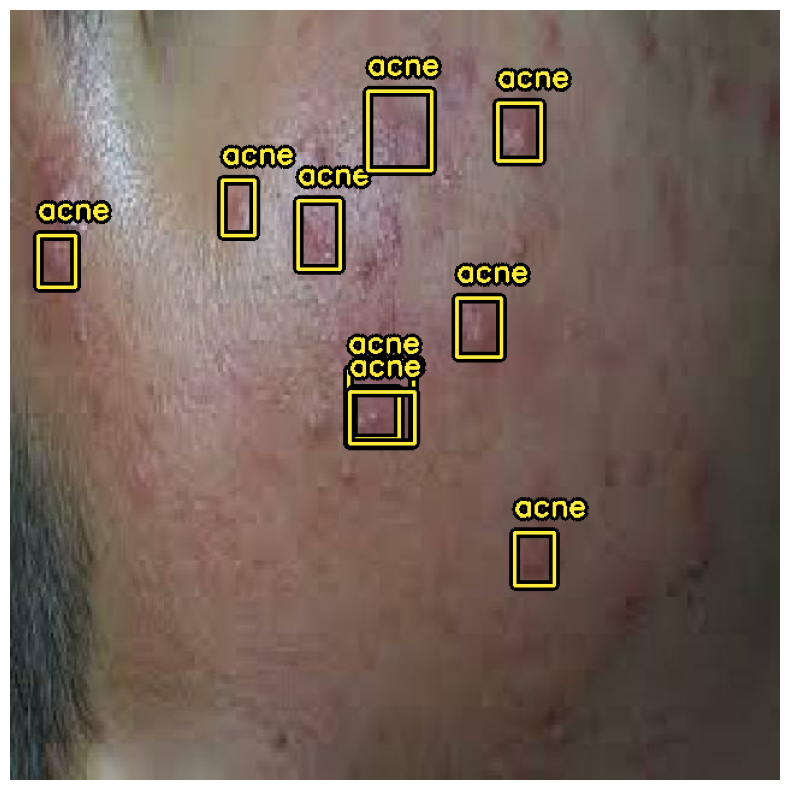

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import keras_cv

# Supondo que você já tenha definido class_mapping, etc.

def visualize_predict_detections(model, dataset, bounding_box_format, confidence_threshold=0.2):
    images, y_true = next(iter(dataset.take(1)))

    # Obtenha as predições brutas do modelo
    y_pred_dict = model.predict(images, verbose = 0) # Armazena o dicionário retornado

    # Supondo que as detecções estejam na chave "detections"
    # Verifique se a chave existe e se o valor é um tensor
    if "boxes" in y_pred_dict and "confidence" in y_pred_dict and "classes" in y_pred_dict:
        boxes = y_pred_dict["boxes"]
        confidences = y_pred_dict["confidence"]
        classes = y_pred_dict["classes"]
        num_detections = y_pred_dict["num_detections"][0] #Pega o valor de detecções

        # Filtra as detecções com base no limiar de confiança
        indices = confidences[0] >= confidence_threshold
        filtered_boxes = boxes[0][indices]
        filtered_confidences = confidences[0][indices]
        filtered_classes = classes[0][indices]

        # Imprima informações para depuração
        print("Número de detecções antes da filtragem:", num_detections)
        print("Número de detecções após a filtragem:", len(filtered_boxes))

        #Cria o dicionário com os bounding boxes filtrados
        y_pred = {"boxes": filtered_boxes, "classes": filtered_classes}
        y_pred = tf.nest.map_structure(tf.convert_to_tensor, y_pred) #Converte tudo para tensor
        y_pred = tf.nest.map_structure(lambda x: tf.expand_dims(x, axis=0), y_pred) #Adiciona a dimensão de batch
        y_pred = keras_cv.bounding_box.to_ragged(y_pred)

        keras_cv.visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            y_true=y_true,
            y_pred=y_pred,
            true_color = (192, 57, 43),
            pred_color=(255, 235, 59),
            scale = 8,
            font_scale = 0.8,
            line_thickness=2,
            dpi = 100,
            rows=1, #Alterado para 1 para mostrar apenas a imagem individual
            cols=1, #Alterado para 1 para mostrar apenas a imagem individual
            show=True,
            class_mapping=class_mapping,
        )
    else:
        print("Erro: As chaves 'boxes', 'confidence' ou 'classes' não foram encontradas no dicionário de predições.")
        print("Conteúdo do dicionário de predições:", y_pred_dict)
        return  # Sai da função se não encontrar a chave esperada

def create_dataset_from_image(image_path):

    # 1. Pré-processamento da imagem (adaptado do seu código)
    def img_preprocessing(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels = 3)
        img = tf.cast(img, tf.float32)
        return img

    image = img_preprocessing(tf.constant(image_path)) #Passa o caminho da imagem como um tensor constante
    image = tf.expand_dims(image, axis=0)  # Adiciona dimensão de lote
    #image = image / 255.0  # Normalização (se necessária - verifique o treinamento)

    #2. Resizing
    resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0), #Removido o scale_factor para não alterar o tamanho da imagem
    bounding_box_format="xyxy")

    #3. Criando o bounding_boxes vazio
    #Cria um batch de bounding boxes vazios
    bounding_boxes = {
        "classes": tf.zeros((1, 0), dtype=tf.float32), # Cria um tensor vazio para classes
        "boxes": tf.zeros((1, 0, 4), dtype=tf.float32)  # Cria um tensor vazio para bounding boxes com a forma correta
    }

    # 4. Criando o dataset
    dataset = tf.data.Dataset.from_tensors(({"images": image, "bounding_boxes": bounding_boxes}))


    #5. Aplicando o resizing
    dataset = dataset.map(resizing, num_parallel_calls = tf.data.AUTOTUNE)

    #6. Convertendo para tupla
    def dict_to_tuple(inputs):
        return inputs["images"], inputs["bounding_boxes"]
    dataset = dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)

    return dataset


# Exemplo de uso:
image_path = "/Users/pedrolucasmirandasouza/Documents/2024.2/Marketing/faceRec/skin-disease-recognition/acne-112_jpeg.rf.a03c796422719e964f46be1c118861bc.jpg"  # Substitua pelo caminho real
dataset = create_dataset_from_image(image_path)

# Carregue os pesos do modelo (se ainda não estiverem carregados)
YOLOV8_model.load_weights('/Users/pedrolucasmirandasouza/Documents/2024.2/Marketing/faceRec/skin-disease-recognition/yolo_acne_detection.h5')

visualize_predict_detections(YOLOV8_model, dataset, bounding_box_format="xyxy", confidence_threshold=0.2)

Número de detecções antes do NMS: 10
Número de detecções após o NMS: 10


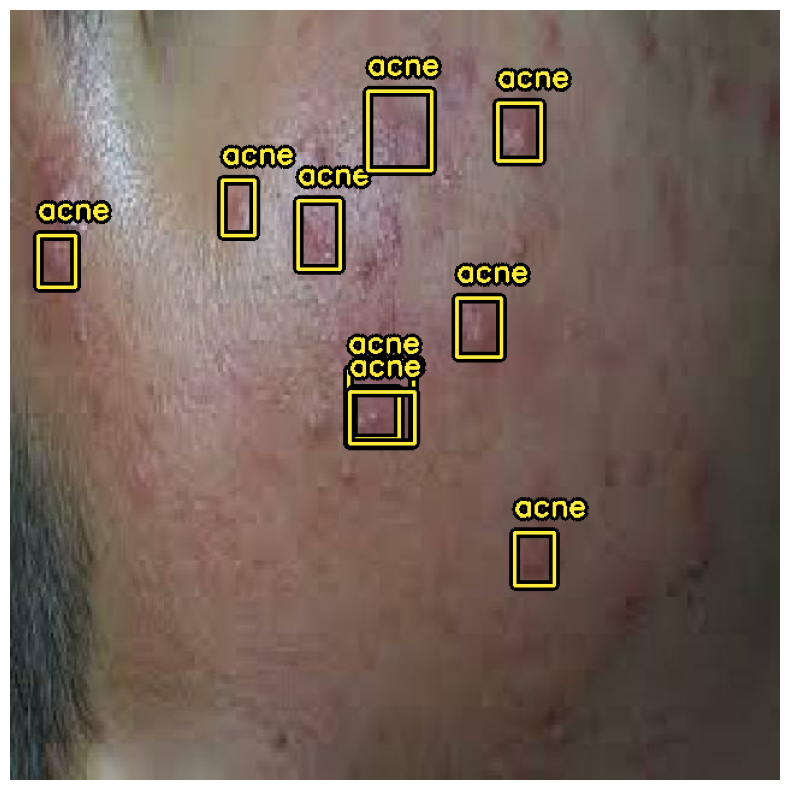

In [42]:
import tensorflow as tf
import numpy as np
from PIL import Image
import keras_cv

# Supondo que você já tenha definido class_mapping, etc.

def apply_nms(boxes, scores, iou_threshold=0.5, score_threshold=0.0):
    """Aplica Non-Maximum Suppression para filtrar bounding boxes."""
    selected_indices = tf.image.non_max_suppression(
        boxes, scores, max_output_size=50,  # Ajuste conforme necessário
        iou_threshold=iou_threshold, score_threshold=score_threshold)
    return selected_indices

def visualize_predict_detections(model, dataset, bounding_box_format, confidence_threshold=0.1, iou_threshold=0.7, nms_score_threshold=0.01): #Valores modificados
    images, y_true = next(iter(dataset.take(1)))

    # Obtenha as predições brutas do modelo
    y_pred_dict = model.predict(images, verbose = 0) # Armazena o dicionário retornado

    # Supondo que as detecções estejam nas chaves "boxes", "confidence" e "classes"
    if "boxes" in y_pred_dict and "confidence" in y_pred_dict and "classes" in y_pred_dict:
        boxes = y_pred_dict["boxes"]
        confidences = y_pred_dict["confidence"]
        classes = y_pred_dict["classes"]
        num_detections = y_pred_dict["num_detections"][0] #Pega o valor de detecções

        # Aplica NMS
        selected_indices = apply_nms(boxes[0], confidences[0], iou_threshold=iou_threshold, score_threshold=nms_score_threshold)

        filtered_boxes = tf.gather(boxes[0], selected_indices)
        filtered_confidences = tf.gather(confidences[0], selected_indices)
        filtered_classes = tf.gather(classes[0], selected_indices)

        # Imprima informações para depuração
        print("Número de detecções antes do NMS:", num_detections)
        print("Número de detecções após o NMS:", len(filtered_boxes))

        #Cria o dicionário com os bounding boxes filtrados
        y_pred = {"boxes": filtered_boxes, "classes": filtered_classes}
        y_pred = tf.nest.map_structure(tf.convert_to_tensor, y_pred) #Converte tudo para tensor
        y_pred = tf.nest.map_structure(lambda x: tf.expand_dims(x, axis=0), y_pred) #Adiciona a dimensão de batch
        y_pred = keras_cv.bounding_box.to_ragged(y_pred)

        keras_cv.visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            y_true=y_true,
            y_pred=y_pred,
            true_color = (192, 57, 43),
            pred_color=(255, 235, 59),
            scale = 8,
            font_scale = 0.8,
            line_thickness=2,
            dpi = 100,
            rows=1, #Alterado para 1 para mostrar apenas a imagem individual
            cols=1, #Alterado para 1 para mostrar apenas a imagem individual
            show=True,
            class_mapping=class_mapping,
        )
    else:
        print("Erro: As chaves 'boxes', 'confidence' ou 'classes' não foram encontradas no dicionário de predições.")
        print("Conteúdo do dicionário de predições:", y_pred_dict)
        return  # Sai da função se não encontrar a chave esperada

def create_dataset_from_image(image_path):
    """Cria um dataset tf.data.Dataset a partir de uma única imagem."""

    # 1. Pré-processamento da imagem (adaptado do seu código)
    def img_preprocessing(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels = 3)
        img = tf.cast(img, tf.float32)
        return img

    image = img_preprocessing(tf.constant(image_path)) #Passa o caminho da imagem como um tensor constante
    image = tf.expand_dims(image, axis=0)  # Adiciona dimensão de lote
    #image = image / 255.0  # Normalização (se necessária - verifique o treinamento)

    #2. Resizing
    resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0), #Removido o scale_factor para não alterar o tamanho da imagem
    bounding_box_format="xyxy")

    #3. Criando o bounding_boxes vazio
    #Cria um batch de bounding boxes vazios
    bounding_boxes = {
        "classes": tf.zeros((1, 0), dtype=tf.float32), # Cria um tensor vazio para classes
        "boxes": tf.zeros((1, 0, 4), dtype=tf.float32)  # Cria um tensor vazio para bounding boxes com a forma correta
    }

    # 4. Criando o dataset
    dataset = tf.data.Dataset.from_tensors(({"images": image, "bounding_boxes": bounding_boxes}))


    #5. Aplicando o resizing
    dataset = dataset.map(resizing, num_parallel_calls = tf.data.AUTOTUNE)

    #6. Convertendo para tupla
    def dict_to_tuple(inputs):
        return inputs["images"], inputs["bounding_boxes"]
    dataset = dataset.map(dict_to_tuple, num_parallel_calls = tf.data.AUTOTUNE)

    return dataset


# Exemplo de uso:
image_path = "/Users/pedrolucasmirandasouza/Documents/2024.2/Marketing/faceRec/skin-disease-recognition/acne-112_jpeg.rf.a03c796422719e964f46be1c118861bc.jpg"  # Substitua pelo caminho real
dataset = create_dataset_from_image(image_path)

# Carregue os pesos do modelo (se ainda não estiverem carregados)
YOLOV8_model.load_weights('/Users/pedrolucasmirandasouza/Documents/2024.2/Marketing/faceRec/skin-disease-recognition/yolo_acne_detection.h5')

visualize_predict_detections(YOLOV8_model, dataset, bounding_box_format="xyxy", confidence_threshold=0.1, iou_threshold=0.7, nms_score_threshold=0.01)